In [38]:
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Resize, ToTensor
from torchvision.datasets import OxfordIIITPet
from einops.layers.torch import Rearrange
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from torch import Tensor, nn
import torch.optim as optim
from random import random
import numpy as np
import torch

In [12]:
to_tensor = [Resize((144,144)), ToTensor()]

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: .


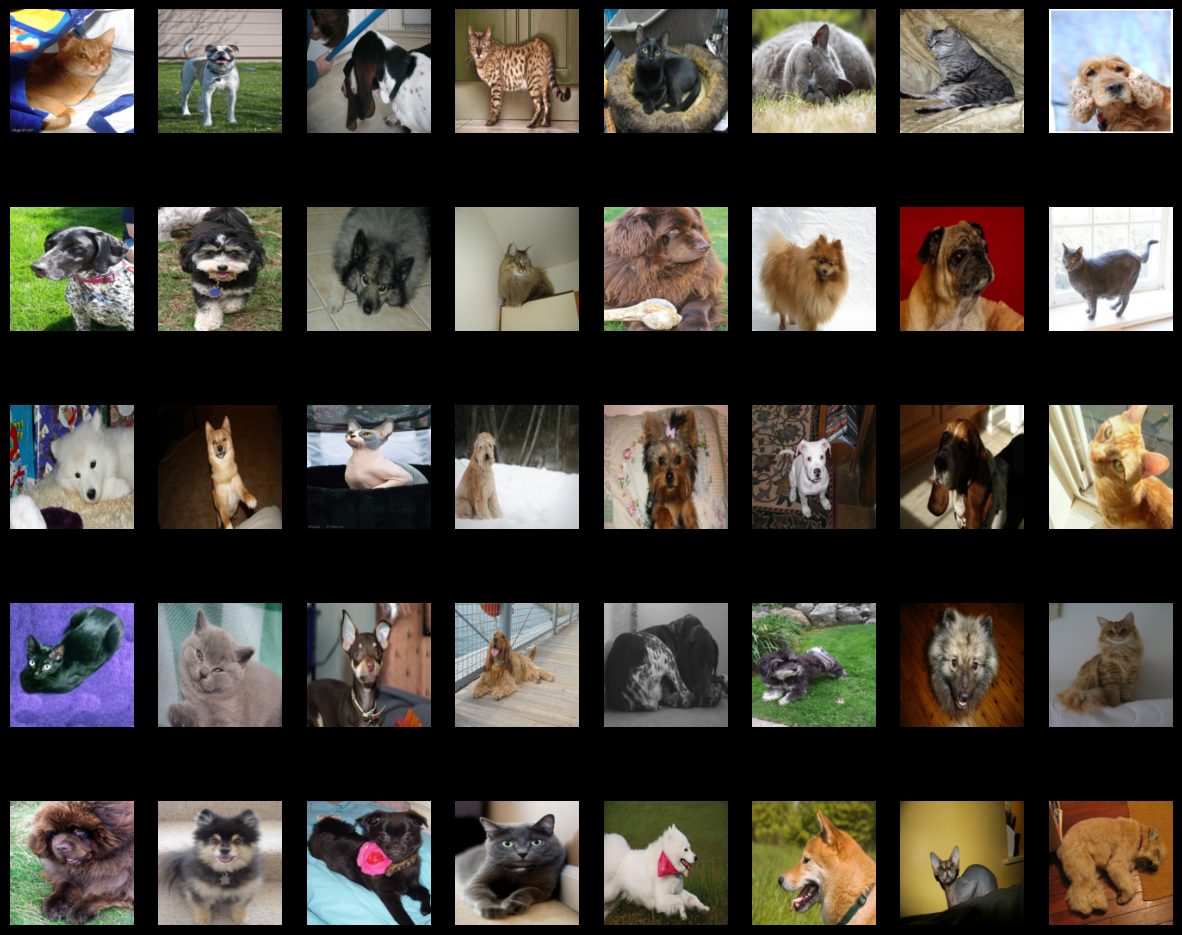

In [13]:
class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image, target):
    for t in self.transforms:
      image = t(image)
    return image, target

def show_images(images, num_samples=40, cols=8):
  """ Plots some samples from the dataset """
  plt.figure(figsize=(15,15))
  idx = int(len(dataset) / num_samples)
  print(images)
  for i, img in enumerate(images):
    if i % idx == 0:
      plt.subplot(int(num_samples/cols) + 1, cols, int(i/idx) + 1)
      plt.imshow(to_pil_image(img[0]))
      plt.axis('off')

# 200 images for each pet
dataset = OxfordIIITPet(root=".", download=True, transforms=Compose(to_tensor))
show_images(dataset)

In [14]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels = 3, patch_size = 8, emb_size = 128):
    self.patch_size = patch_size
    super().__init__()
    self.projection = nn.Sequential(
      # break-down the image in s1 x s2 patches and flat them
      Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
      nn.Linear(patch_size * patch_size * in_channels, emb_size)
    )

  def forward(self, x: Tensor) -> Tensor:
    x = self.projection(x)
    return x

# Run a quick test
sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
print("Initial shape: ", sample_datapoint.shape)
embedding = PatchEmbedding()(sample_datapoint)
print("Patches shape: ", embedding.shape)

Initial shape:  torch.Size([1, 3, 144, 144])
Patches shape:  torch.Size([1, 324, 128])


In [15]:
class Attention(nn.Module):
  def __init__(self, dim, n_heads, dropout):
    super().__init__()
    self.n_heads = n_heads
    self.att = nn.MultiheadAttention(dim, n_heads, dropout)
    self.q = nn.Linear(dim, dim)
    self.k = nn.Linear(dim, dim)
    self.v = nn.Linear(dim, dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attn_output, attn_output_weights = self.att(q, k, v)
    return attn_output

In [16]:
Attention(128, 4, 0.1)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [32]:
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn

  def forward(self, x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

In [33]:
norm = PreNorm(128, Attention(128, 4, 0.1))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [34]:
class FeedForward(nn.Sequential):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__(
      nn.Linear(dim, hidden_dim),
      nn.GELU(),
      nn.Dropout(dropout),
      nn.Linear(hidden_dim, dim),
      nn.Dropout(dropout)
    )

ff = FeedForward(128, 256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [35]:
class ResidualAdd(nn.Module):
  def __init__(self, fn):
    super().__init__()
    self.fn = fn

  def forward(self, x, **kwargs):
    res = x
    x = self.fn(x, **kwargs)
    x += res
    return x

In [ ]:
class ViT(nn.Module):
  def __init__(self, ch=3, img_size=144, patch_size=8, emb_dim=32,
               n_layers=4, out_dim=37, dropout=0.1, heads=2):
    super(ViT, self).__init__()

    # Attributes
    self.channels = ch
    self.height = img_size
    self.width = img_size
    self.patch_size = patch_size
    self.n_layers = n_layers

    # Patch embedding
    self.patch_embedding = PatchEmbedding(ch, patch_size, emb_dim)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

    # Transformer Encoder
    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      transformer_block = nn.Sequential(
        ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, heads, dropout))),
        ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout)))
      )
      self.layers.append(transformer_block)

    # Classification head
    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim))

  def forward(self, img):
    # Get patch embedding vectors
    x = self.patch_embedding(img)
    b, n, _ = x.shape

    # Add CLS token to inputs
    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
    x = torch.cat((cls_tokens, x), dim=1)
    x += self.pos_embedding[:, :(n + 1)]

    # Transformer Encoder
    for i in range(self.n_layers):
      x = self.layers[i](x)

    return self.classification_head(x[:, 0, :])

In [47]:
model = ViT()
model(torch.ones((1, 3, 144, 144))).shape

torch.Size([1, 37])

--- 
# Training

In [48]:
train_split = int(0.8 * len(dataset))
train, test = random_split(dataset, [train_split, len(dataset) - train_split])

train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test, batch_size=32, shuffle=True)

In [51]:
device = "mps"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1000):
  epoch_losses = []
  model.train()
  for step, (inputs, labels) in enumerate(train_dataloader):
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  if epoch % 5 == 0:
    print(f">>> Epoch {epoch} train loss: ", np.mean(epoch_losses))
    epoch_losses = []
    # Something was strange when using this?
    # model.eval()
    for step, (inputs, labels) in enumerate(test_dataloader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      epoch_losses.append(loss.item())
    print(f">>> Epoch {epoch} test loss:  ", np.mean(epoch_losses))

>>> Epoch 0 train loss:  3.653972213682921
>>> Epoch 0 test loss:   3.619034818981005
>>> Epoch 5 train loss:  3.623903722866722
>>> Epoch 5 test loss:   3.624513512072356
>>> Epoch 10 train loss:  3.6222568620806155
>>> Epoch 10 test loss:   3.620303257651951
>>> Epoch 15 train loss:  3.6213827858800474
>>> Epoch 15 test loss:   3.622867335443911
>>> Epoch 20 train loss:  3.619837227074996
>>> Epoch 20 test loss:   3.61706282781518
>>> Epoch 25 train loss:  3.6193193456400996
>>> Epoch 25 test loss:   3.6194353103637695
>>> Epoch 30 train loss:  3.6176257729530334
>>> Epoch 30 test loss:   3.6196259830309
>>> Epoch 35 train loss:  3.6177241828130637
>>> Epoch 35 test loss:   3.6187432123267134
>>> Epoch 40 train loss:  3.6158711288286294
>>> Epoch 40 test loss:   3.6185815230659815
>>> Epoch 45 train loss:  3.616998120494511
>>> Epoch 45 test loss:   3.617560925691024
>>> Epoch 50 train loss:  3.616503357887268
>>> Epoch 50 test loss:   3.6204531607420547
>>> Epoch 55 train loss:  3.6